# Stacking 

It is the third ensamble learning which stacking

sometime problems are so complex that one model cannot capture all patterns present in the data

so for this particular situation we have solution called as stacking 

In this method what we do is , we pickout some trained method , some trained algorithm and create a linear combination of these algorithm 

The linear combination of these algorihm will help us in getting better output 



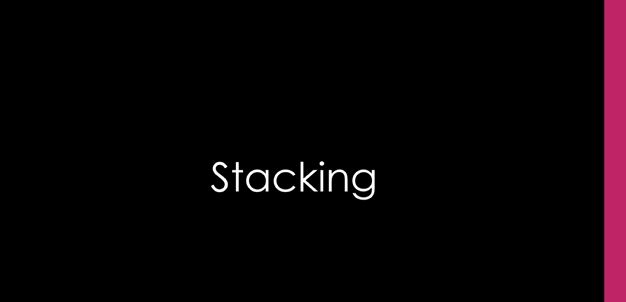

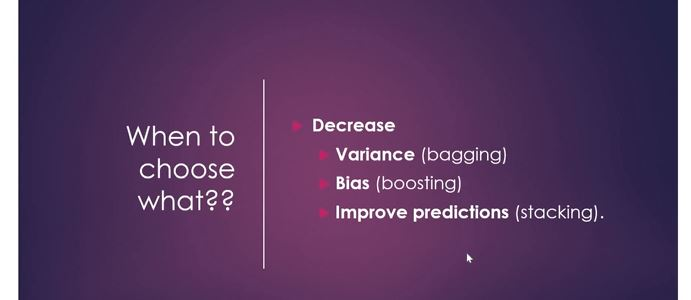

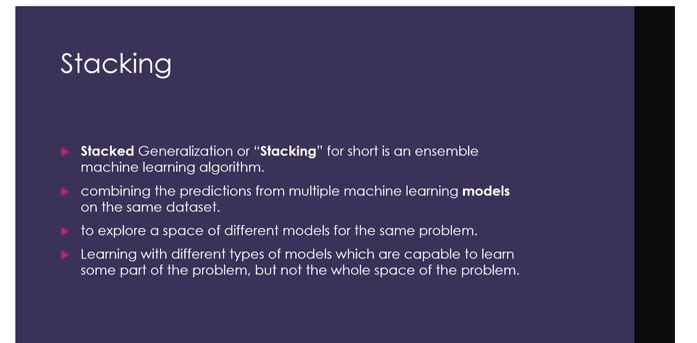

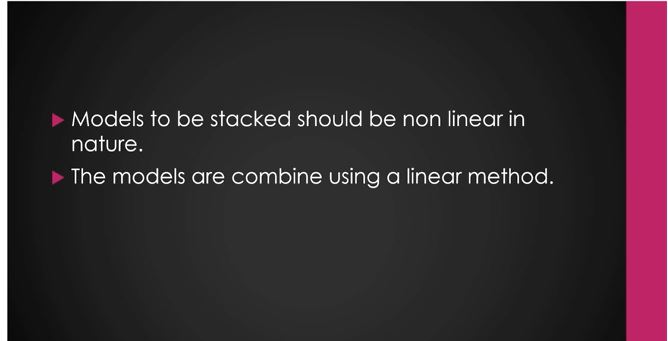

Let's say we have one linear regression , one random forest , one xgbbost another SVM model 
and these models are performing very decently on their own part of the data , but they are not able to capture one or other part of thhe pattern that is present in the data

So in that case we will combine the power of all of thesse good performers and get a very strong performer 

which is called a stacked model which will be created by combining the powers of all of these algorithms 

------------------------------------------------------
------------------------------------------------------

Now let's look at the entire process 

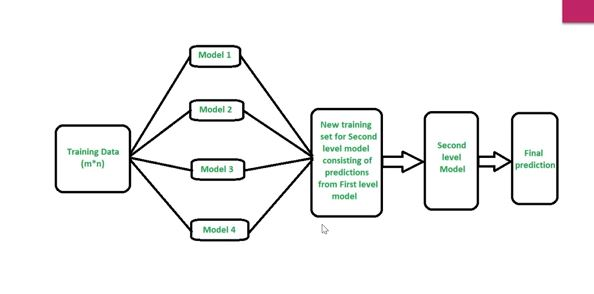

So let's say we have our training data which is m*n(m-number of rows , n-number of columns )

we will train any number of model on given data here we have trained 4 model 

now we will hav esome prediction from these models and we will combine them and we will create another prediction by combining all the output and make other new output 

if it is still not performing well then we will introduce another layer which will work on output of first layer and try to improve them 

# Process

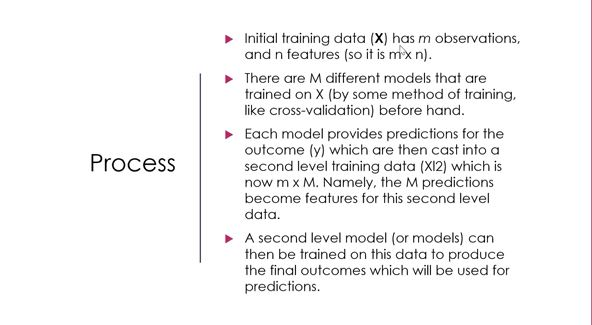

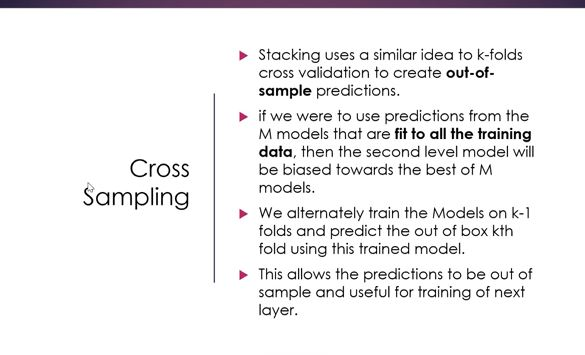

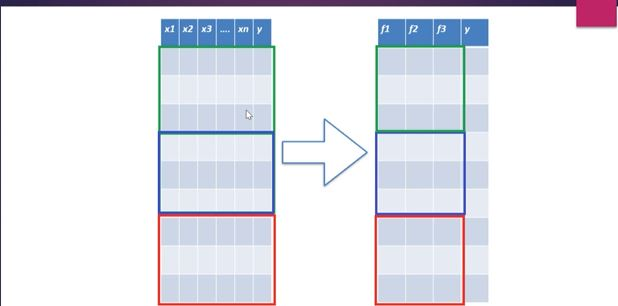

So let's say we have created 3 folds here

so what we can do we can train the data o first two blocks (folds) and make a prediction on 3rd folds 

now next time we will train all the models on the next 2 folds and make prediction on the first folds 

last we will train all the models on the 1st and 3rd  folds and make prediction on the second folds 

now the prediction from the model we have f1,f2,f3

so now these output will be act as input in the next layer 

# Stacking code 

In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

So in stacking we will be using different nonlinear model in the first layer and we wil be providing linear model in the second layer 
herew e are evaluating using roc_auc_score

for model selection we are using k fold 

In [2]:
file=r'census_income.csv'

cd= pd.read_csv(file)

cd['Y']=(cd['Y']==' >50K').astype(int)

In [3]:
cd


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


here we are using income dataset

inthis dataset we ahve different y values as greater than 50k or less than 50k 

we have seen this data earlier also 

In [6]:
cd.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
Y                  int32
dtype: object

In [7]:
del cd['education']

cat_cols=cd.select_dtypes(['object']).columns

for col in cat_cols:
    freqs=cd[col].value_counts()
    k=freqs.index[freqs>99][:-1]
    for cat in k:
        name=col+'_'+cat
        cd[name]=(cd[col]==cat).astype(int)
    del cd[col]
    print(col)
    
cd_train,cd_test=train_test_split(cd,test_size=0.2,random_state=2)

cd_train.reset_index(drop=True,inplace=True)
cd_test.reset_index(drop=True,inplace=True)

x_train=cd_train.drop(['Y'],axis=1)
y_train=cd_train['Y']

x_test=cd_test.drop(['Y'],axis=1)
y_test=cd_test['Y']

workclass
marital.status
occupation
relationship
race
sex
native.country


First we have deleted education column 

after that we have selected all the object columns 

and on this object columns we have ran loop 

this loop check if particular category contain more than 99 values than only it will be converted to dummy varaiable otherwise it will skip that 

we can use any frequency

after that we have made train test split and retrive the dataset 

In [8]:
clf1=KNeighborsClassifier(n_neighbors=50)
clf2=RandomForestClassifier(class_weight='balanced',n_estimators=200)
clf3=RandomForestClassifier(class_weight=None,n_estimators=100)
clf4=XGBClassifier(n_estimators=150,objective='binary:logistic',learning_rate=.01)
clf5=XGBClassifier(n_estimators=150,objective='binary:logistic',learning_rate=.1)

Algos=[clf1,clf2,clf3,clf4,clf5]

These are the different algorithm which we are usning 

In [9]:
rows=x_train.shape[0]

In [10]:
rows

26048

In [11]:
layer1=pd.DataFrame({'clf1':np.zeros(rows),'clf2':np.zeros(rows),'clf3':np.zeros(rows),
                    'clf4':np.zeros(rows),'clf5':np.zeros(rows)})

In [13]:
layer1

,clf1,clf2,clf3,clf4,clf5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
26043,0.0,0.0,0.0,0.0,0.0
26044,0.0,0.0,0.0,0.0,0.0
26045,0.0,0.0,0.0,0.0,0.0
26046,0.0,0.0,0.0,0.0,0.0


In [14]:
kf=KFold(n_splits=10)

In [15]:
fold=1
for train,left_out_chunk in kf.split(x_train):
    print('fold number : ', fold)
    
    for i,clf in enumerate(Algos):
        print('Algo number :',i+1)
        
        x_train_train=x_train.loc[train]
        y_train_train=y_train[train]
        x_train_left_out_chunk=x_train.loc[left_out_chunk]
        
        clf.fit(x_train_train,y_train_train)
        p=clf.predict_proba(x_train_left_out_chunk)[:,1]
        
        layer1.iloc[left_out_chunk,i]=p
        
    fold+=1  
    

fold number :  1
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Algo number : 5
[21:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  2
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  3
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  4
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  5
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  6
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  7
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:40:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  8
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  9
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number : 5
[21:41:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold number :  10
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
[21:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Algo number : 5
[21:42:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


so here we are creating k fold and 10 splits out of total data 

we are begning with fold 1 

and we are splitting the x_train data into left_out_chunk and train in 10 parts 

and then we are printing the fold detail, the number of folds 

In [16]:
layer1

,clf1,clf2,clf3,clf4,clf5
0,0.16,0.125,0.14,0.346062,0.137024
1,0.12,0.005,0.00,0.123436,0.005264
2,0.10,0.000,0.01,0.115820,0.000603
3,0.18,0.190,0.18,0.465752,0.341229
4,0.20,0.010,0.01,0.170925,0.022361
...,...,...,...,...,...
26043,0.14,0.935,0.91,0.887607,0.990906
26044,0.12,0.175,0.15,0.235990,0.174249
26045,0.32,0.545,0.58,0.443023,0.950036
26046,0.14,0.000,0.00,0.115096,0.000563


Now we will give this layer1 data as input to layer 2

In [17]:
rows=x_test.shape[0]
layer2_test=pd.DataFrame({'clf1':np.zeros(rows),'clf2':np.zeros(rows),'clf3':np.zeros(rows),
                    'clf4':np.zeros(rows),'clf5':np.zeros(rows)})

In [18]:
for i,clf in enumerate(Algos):
    print( 'Algo number',i+1)
    clf.fit(x_train,y_train)
    p=clf.predict_proba(x_test)[:,1]
    
    layer2_test.iloc[:,i]=p


Algo number 1
Algo number 2
Algo number 3
Algo number 4
[21:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Algo number 5
[21:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
layer2_test

,clf1,clf2,clf3,clf4,clf5
0,0.22,0.075,0.07,0.130232,0.028808
1,0.26,0.010,0.00,0.130232,0.014762
2,0.12,0.255,0.24,0.574716,0.493914
3,0.16,0.190,0.12,0.358768,0.306357
4,0.24,0.085,0.10,0.115387,0.028397
...,...,...,...,...,...
6508,0.12,0.000,0.01,0.115387,0.009968
6509,0.40,1.000,0.97,0.880204,0.978483
6510,0.48,0.980,0.96,0.886972,0.986630
6511,0.26,0.000,0.00,0.115387,0.003361


In [20]:
# second layer linear model 
logr=LogisticRegression(class_weight='balanced')

In [21]:
logr.fit(layer1,y_train)

C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
roc_auc_score(y_test,logr.predict_proba(layer2_test)[:,1])

0.9218757681592855

In [23]:
xgb2=XGBClassifier(objective='binary:logistic',n_estimators=100,max_depth=3,learning_rate=.1,scale_pos_weight=3)

In [25]:
xgb2.fit(layer1,y_train)

C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [26]:
roc_auc_score(y_test,xgb2.predict_proba(layer2_test)[:,1])

0.9220932212503583